In [1]:
import os
import pandas as pd
import numpy as np
import glob

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

%config InlineBackend.figure_formatrmat = 'retina'

In [2]:
from stesml.data_tools import get_train_and_test_index
from stesml.data_tools import load_data
from stesml.data_tools import series_to_supervised
from stesml.data_tools import get_train_data
from stesml.data_tools import get_test_data

from stesml.model_tools import get_model
from stesml.model_tools import walk_forward_validation
from stesml.model_tools import get_predictions
from stesml.model_tools import get_progress
from stesml.model_tools import get_shuffle_results

from stesml.plot_tools import get_plot_data
from stesml.plot_tools import plot_test_results
from stesml.plot_tools import plot_average_error
from stesml.plot_tools import plot_progress_results

from stesml.postprocessing_tools import get_Cp
from stesml.postprocessing_tools import get_Ac
from stesml.postprocessing_tools import get_m
from stesml.postprocessing_tools import get_As
from stesml.postprocessing_tools import get_h
from stesml.postprocessing_tools import get_T

/Users/kmenear/Projects/envSulfurTES/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data_dir = "../data/Sulfur_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "ML_*_*.csv"))})

In [4]:
model_type = "XGBoost"
is_recurrent = False
n_estimators = 10
target = 'h'
per_case = False
x = 0

In [5]:
train_index, test_index = get_train_and_test_index(scenario_index)

X_train, y_train = get_train_data(scenario_index, train_index, test_index, is_recurrent, target=target, per_case=per_case, x=x)
X_test, y_test = get_test_data(scenario_index, test_index, is_recurrent, target=target, x=x)

In [35]:
model = get_model(model_type, n_estimators)

In [11]:
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=30)

In [12]:
y_hat = get_predictions(model, X_test, is_recurrent)

In [13]:
print(r2_score(y_test, y_hat))

0.9946369193346898


In [14]:
print(mean_squared_error(y_test, y_hat, squared=False))

4.0899045177826014


In [15]:
test_df = load_data(scenario_index, test_index, x=x)

In [16]:
test_df["h_hat"] = y_hat

In [17]:
test_df_plot = get_plot_data(y_hat, test_df, test_index, is_recurrent, target=target)

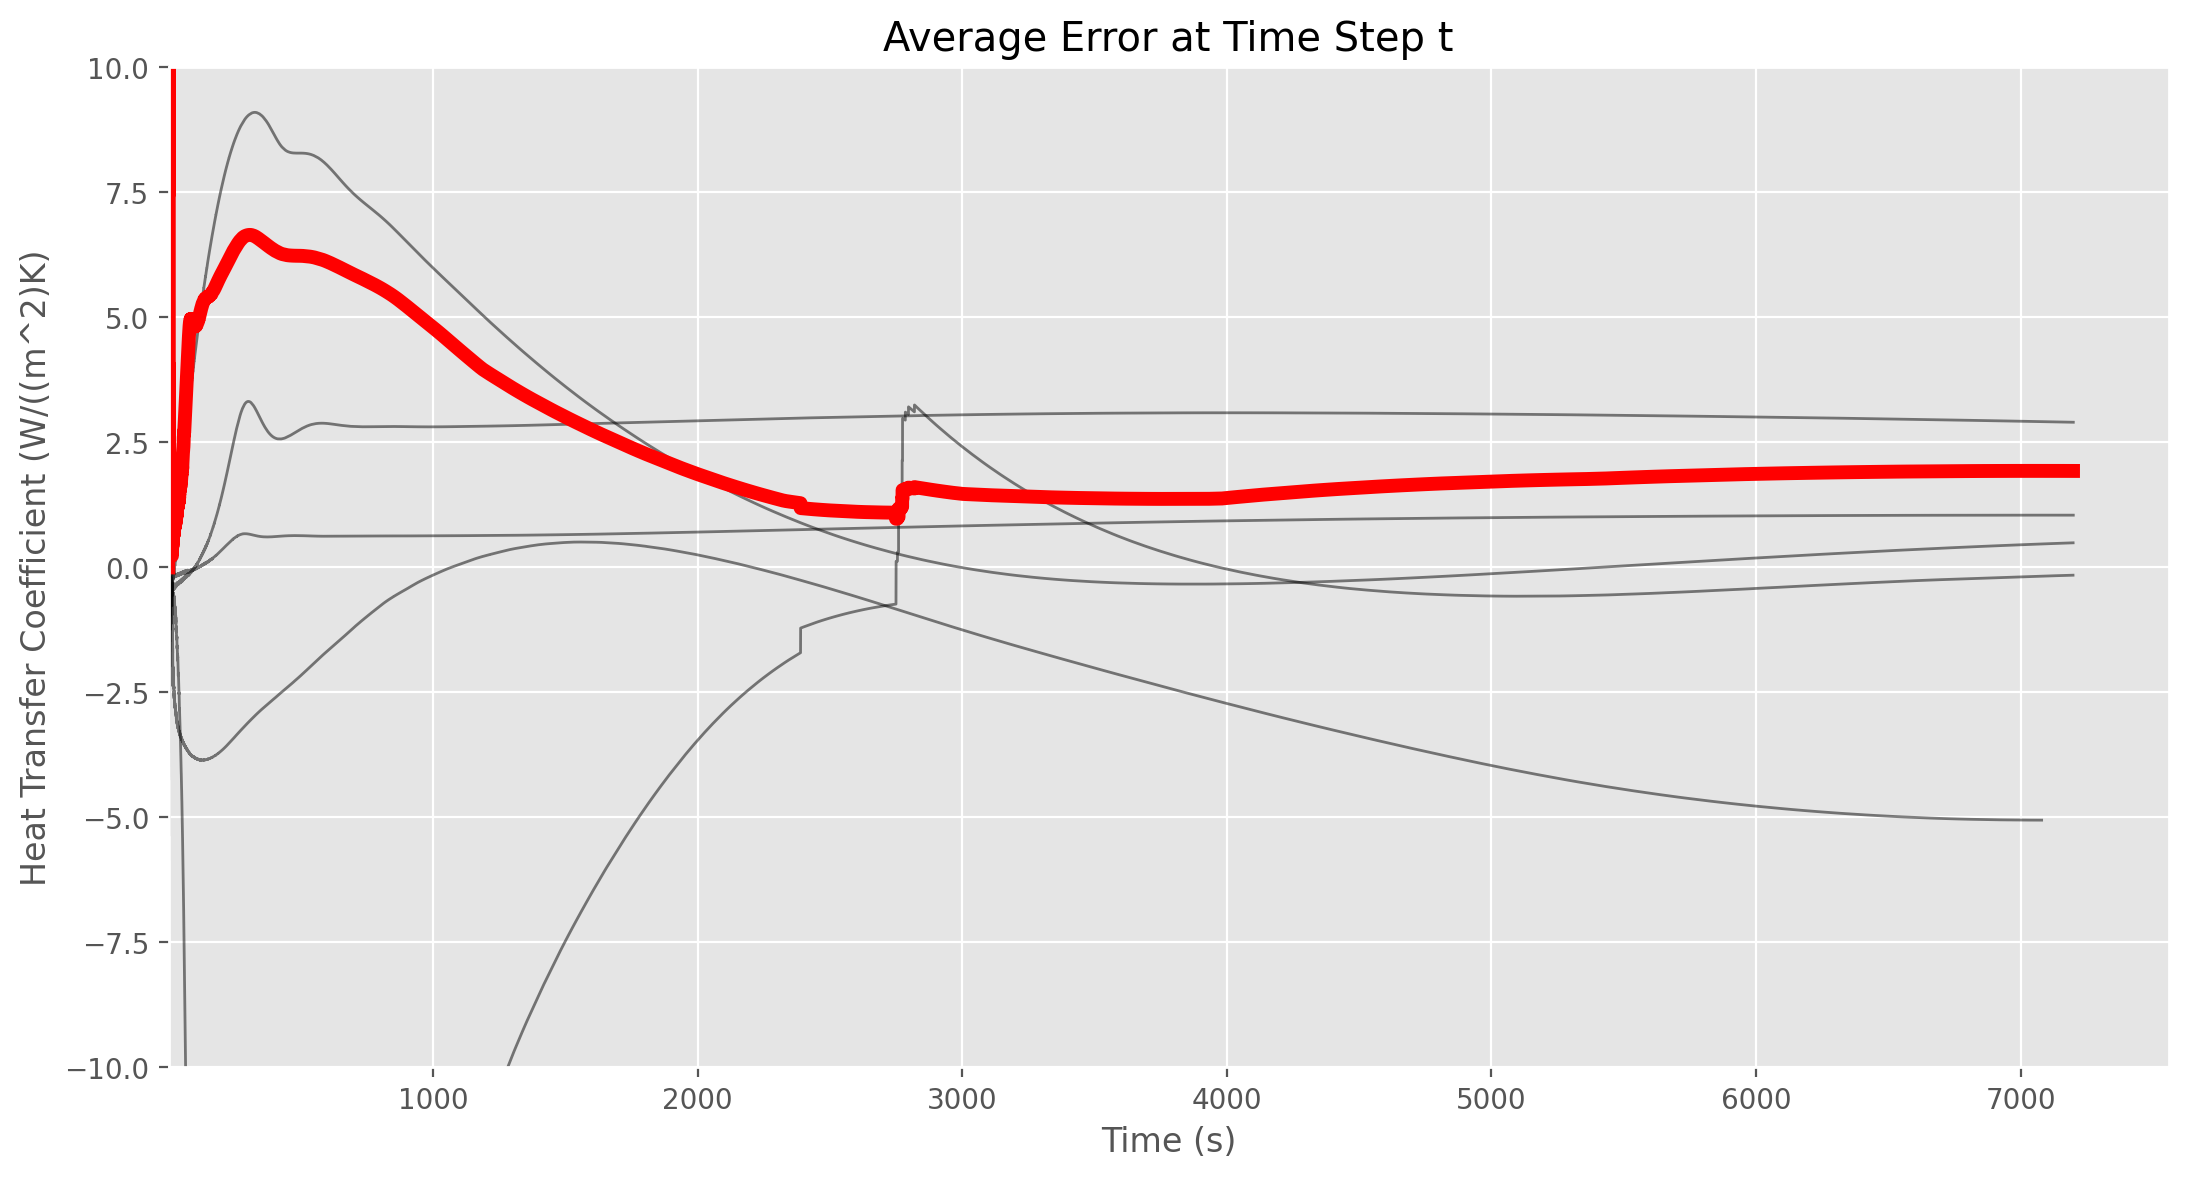

In [18]:
plot_average_error(test_df_plot, target=target)

<AxesSubplot:>

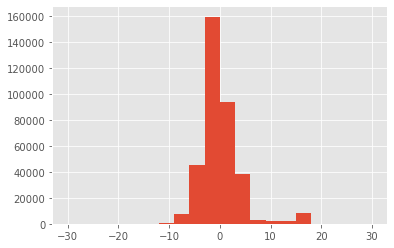

In [19]:
(test_df_plot[target] - test_df_plot[target+'_hat']).hist(bins=20, range=(-30, 30))

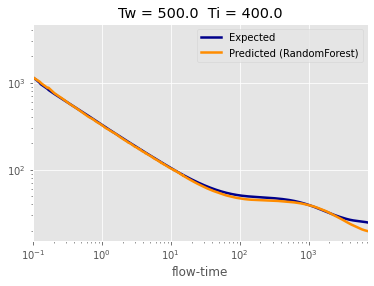

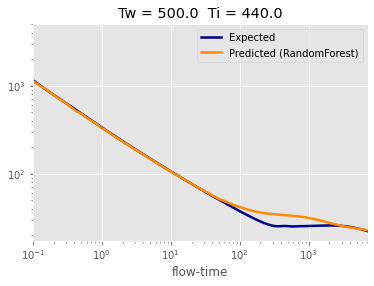

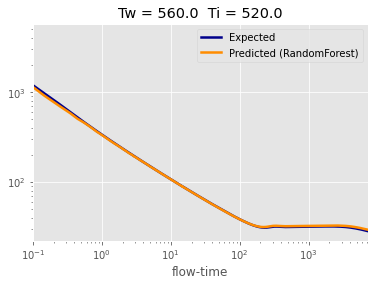

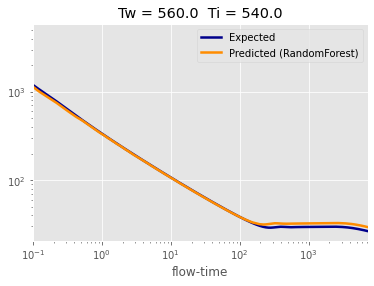

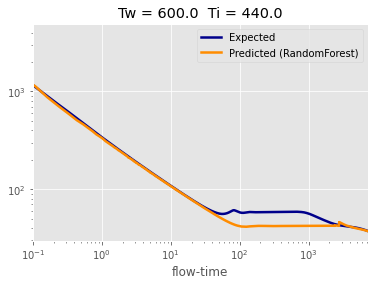

In [21]:
plot_test_results(test_df_plot, model_type, target=target)

[400.         399.99999977 399.99999977 ... 434.40677839 434.40698613
 434.40719388]


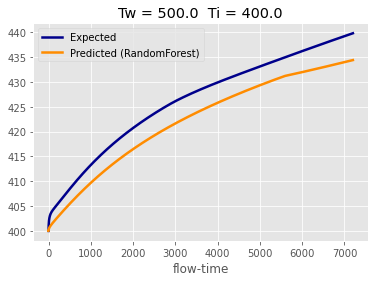

[440.         439.99999974 439.99999974 ... 459.1505011  459.15069246
 459.15088382]


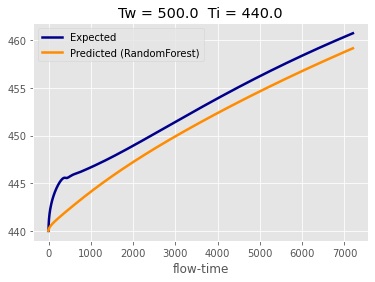

[520.         519.9999997  519.9999997  ... 536.00928056 536.00943633
 536.0095921 ]


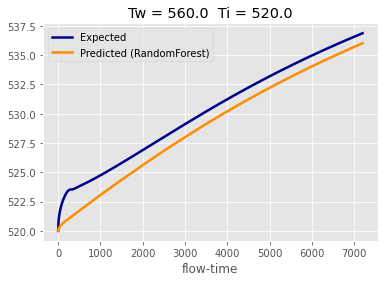

[540.         539.99999969 539.99999969 ... 548.04129091 548.04136888
 548.04144684]


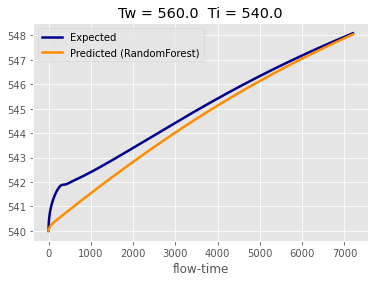

[440.         439.99999974 439.99999974 ... 514.654595   514.65529124
 514.65598747]


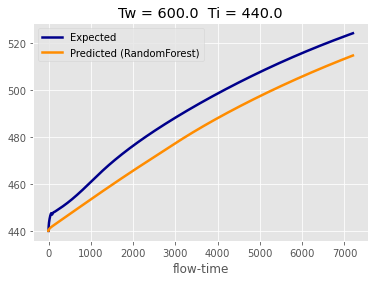

[400.         399.99999977 399.99999977 ... 514.654595   514.65529124
 514.65598747]


In [23]:
T_hat = np.array([])
T_expected = np.array([])
for idx, grp in test_df.groupby(["Tw", "Ti"]):
    T_hat_grp = np.array([])
    Ti = grp["Ti"][0]
    Tw = grp["Tw"][0]
    T_hat_grp = np.append(T_hat_grp, Ti)
    T_prev = Ti
    for i, h in enumerate(grp["h_hat"]):
        if i == len(grp["h_hat"]) - 1:
            continue
        if i < 1:
            T = grp["Tavg"][i]
            T_hat_grp = np.append(T_hat_grp, T)
            T_prev = T
            h_prev = h
            continue
        timestep = grp["flow-time"][i] - grp["flow-time"][i-1]
        T = get_T(T_prev, h_prev, Tw, timestep)
        T_hat_grp = np.append(T_hat_grp, T)
        T_prev = T
        h_prev = h
    print(T_hat_grp)
    # Plotting results
    grp["T_hat"] = T_hat_grp
    ax = grp.plot(x="flow-time", y='Tavg', c='DarkBlue', linewidth=2.5, label="Expected")
    plot = grp.plot(x="flow-time", y='T_hat', c='DarkOrange', linewidth=2.5, label="Predicted ({model_type})".format(model_type=model_type), ax=ax)
    plt.title('Tw = {Tw}  Ti = {Ti}'.format(Tw=idx[0], Ti=idx[1]))
    plt.show()
    T_hat = np.concatenate((T_hat, T_hat_grp))
    T_expected = np.concatenate((T_expected, grp["Tavg"]))
print(T_hat)

In [24]:
print(r2_score(T_expected, T_hat))

0.9892291560625291


In [25]:
print(mean_squared_error(T_expected, T_hat, squared=False))

4.82619308461482


In [4]:
model_type = "XGBoost"
is_recurrent = False
target = 'h'
per_case = False
x = 0

min_estimators = 100
max_estimators = 1000
step_size = 100
n_shuffle_iterations = 5

rmse_history, r2_history = get_progress(model_type, scenario_index, min_estimators, max_estimators, step_size, n_shuffle_iterations, is_recurrent, verbose=1, target=target, per_case=per_case, x=x)

Estimators: 100 Shuffle: 0 RMSE: 2.727106853732485 R2: 0.997622927482216


KeyboardInterrupt: 

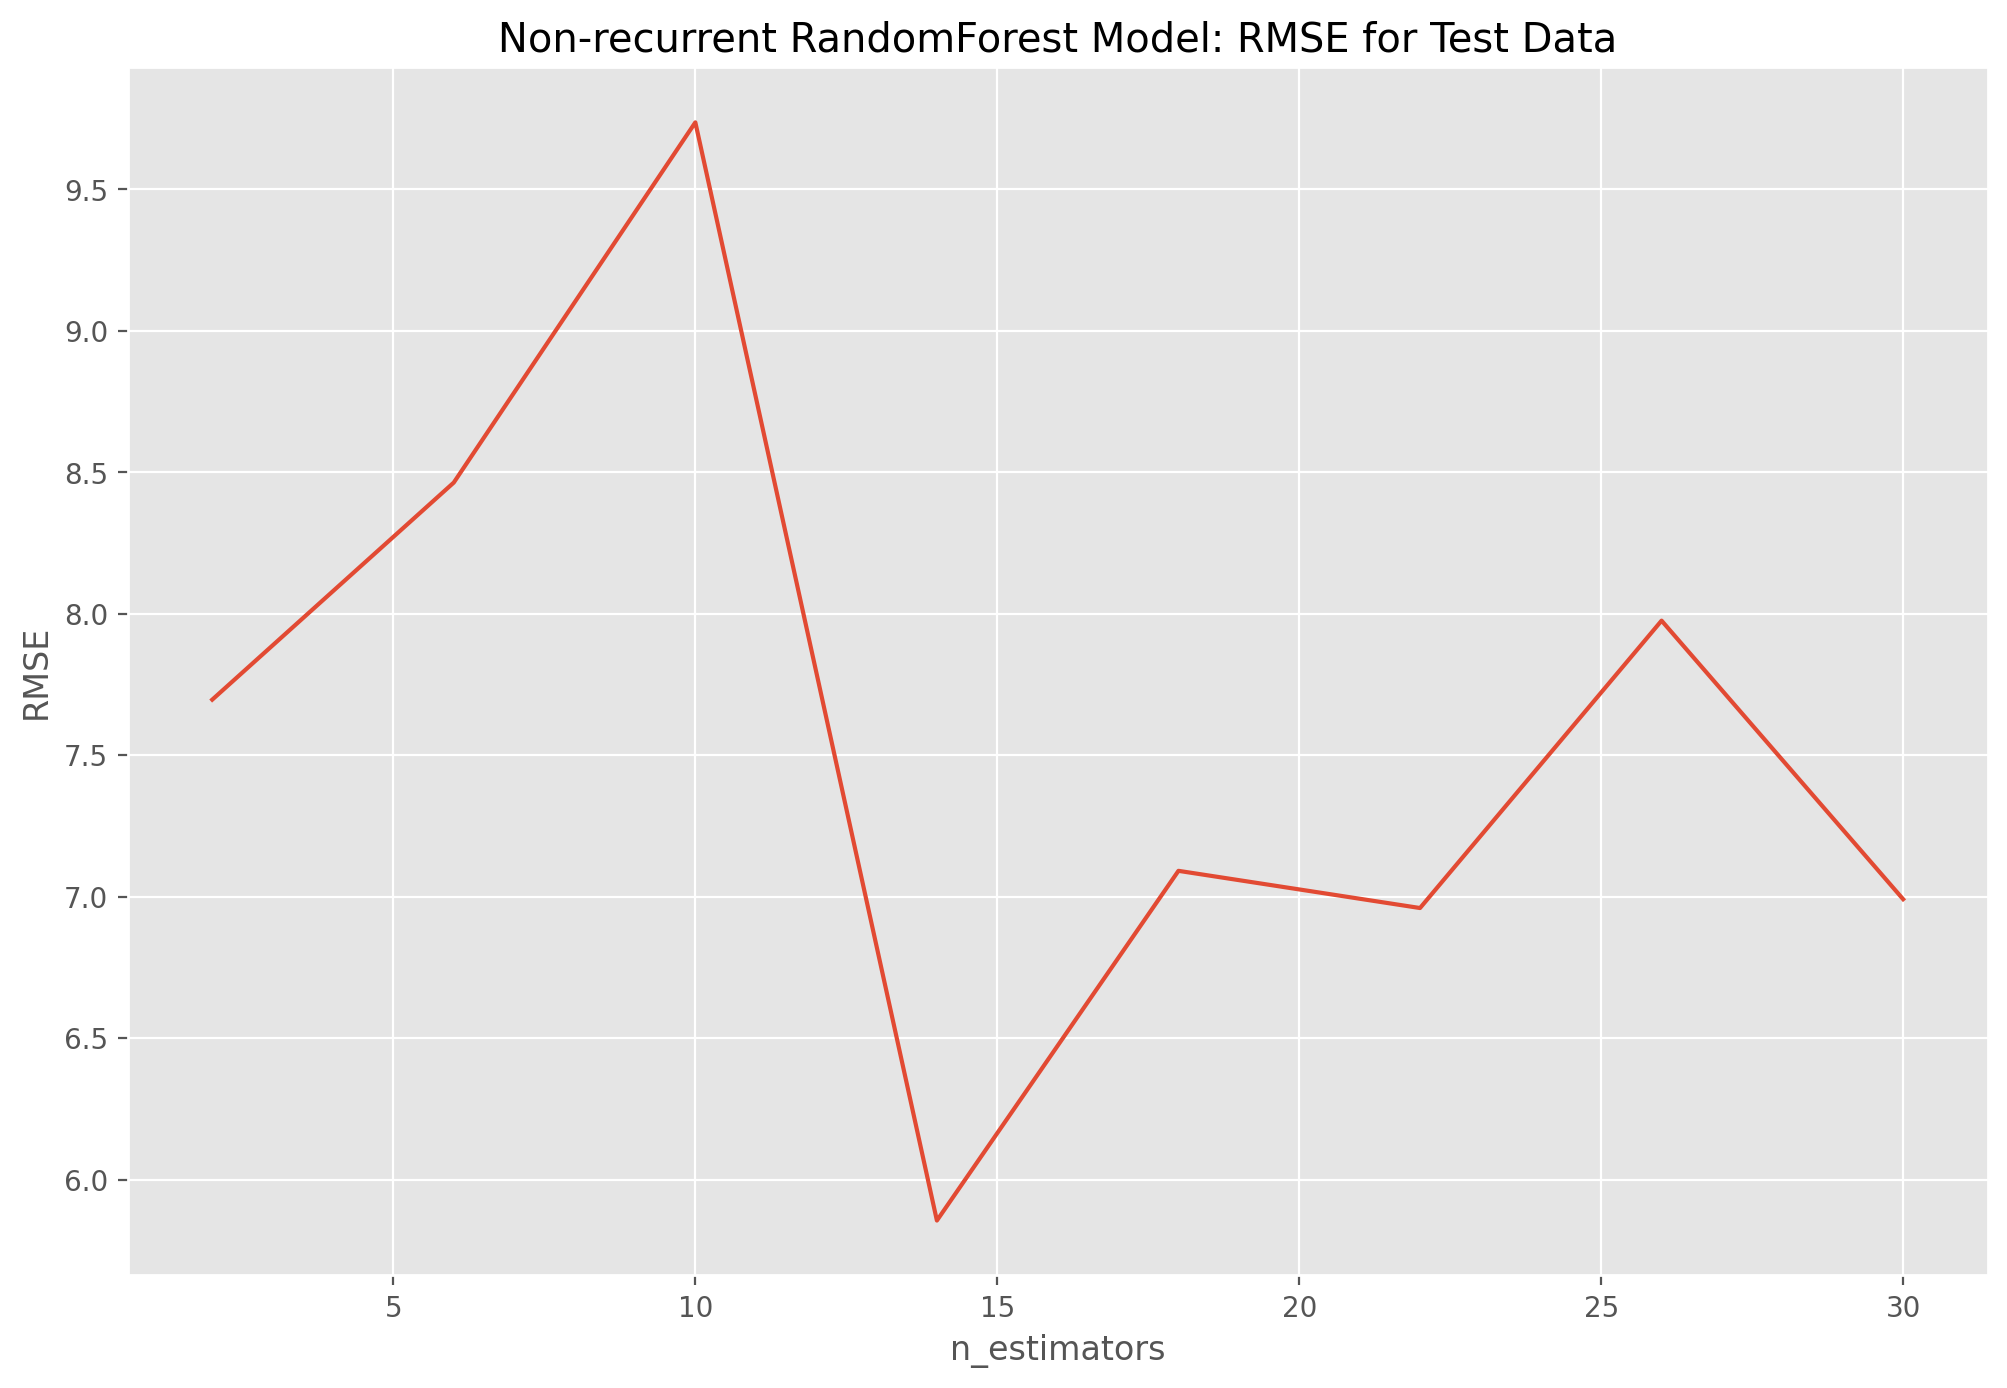

In [27]:
plot_progress_results(rmse_history[0], model_type, is_recurrent, metric="RMSE")

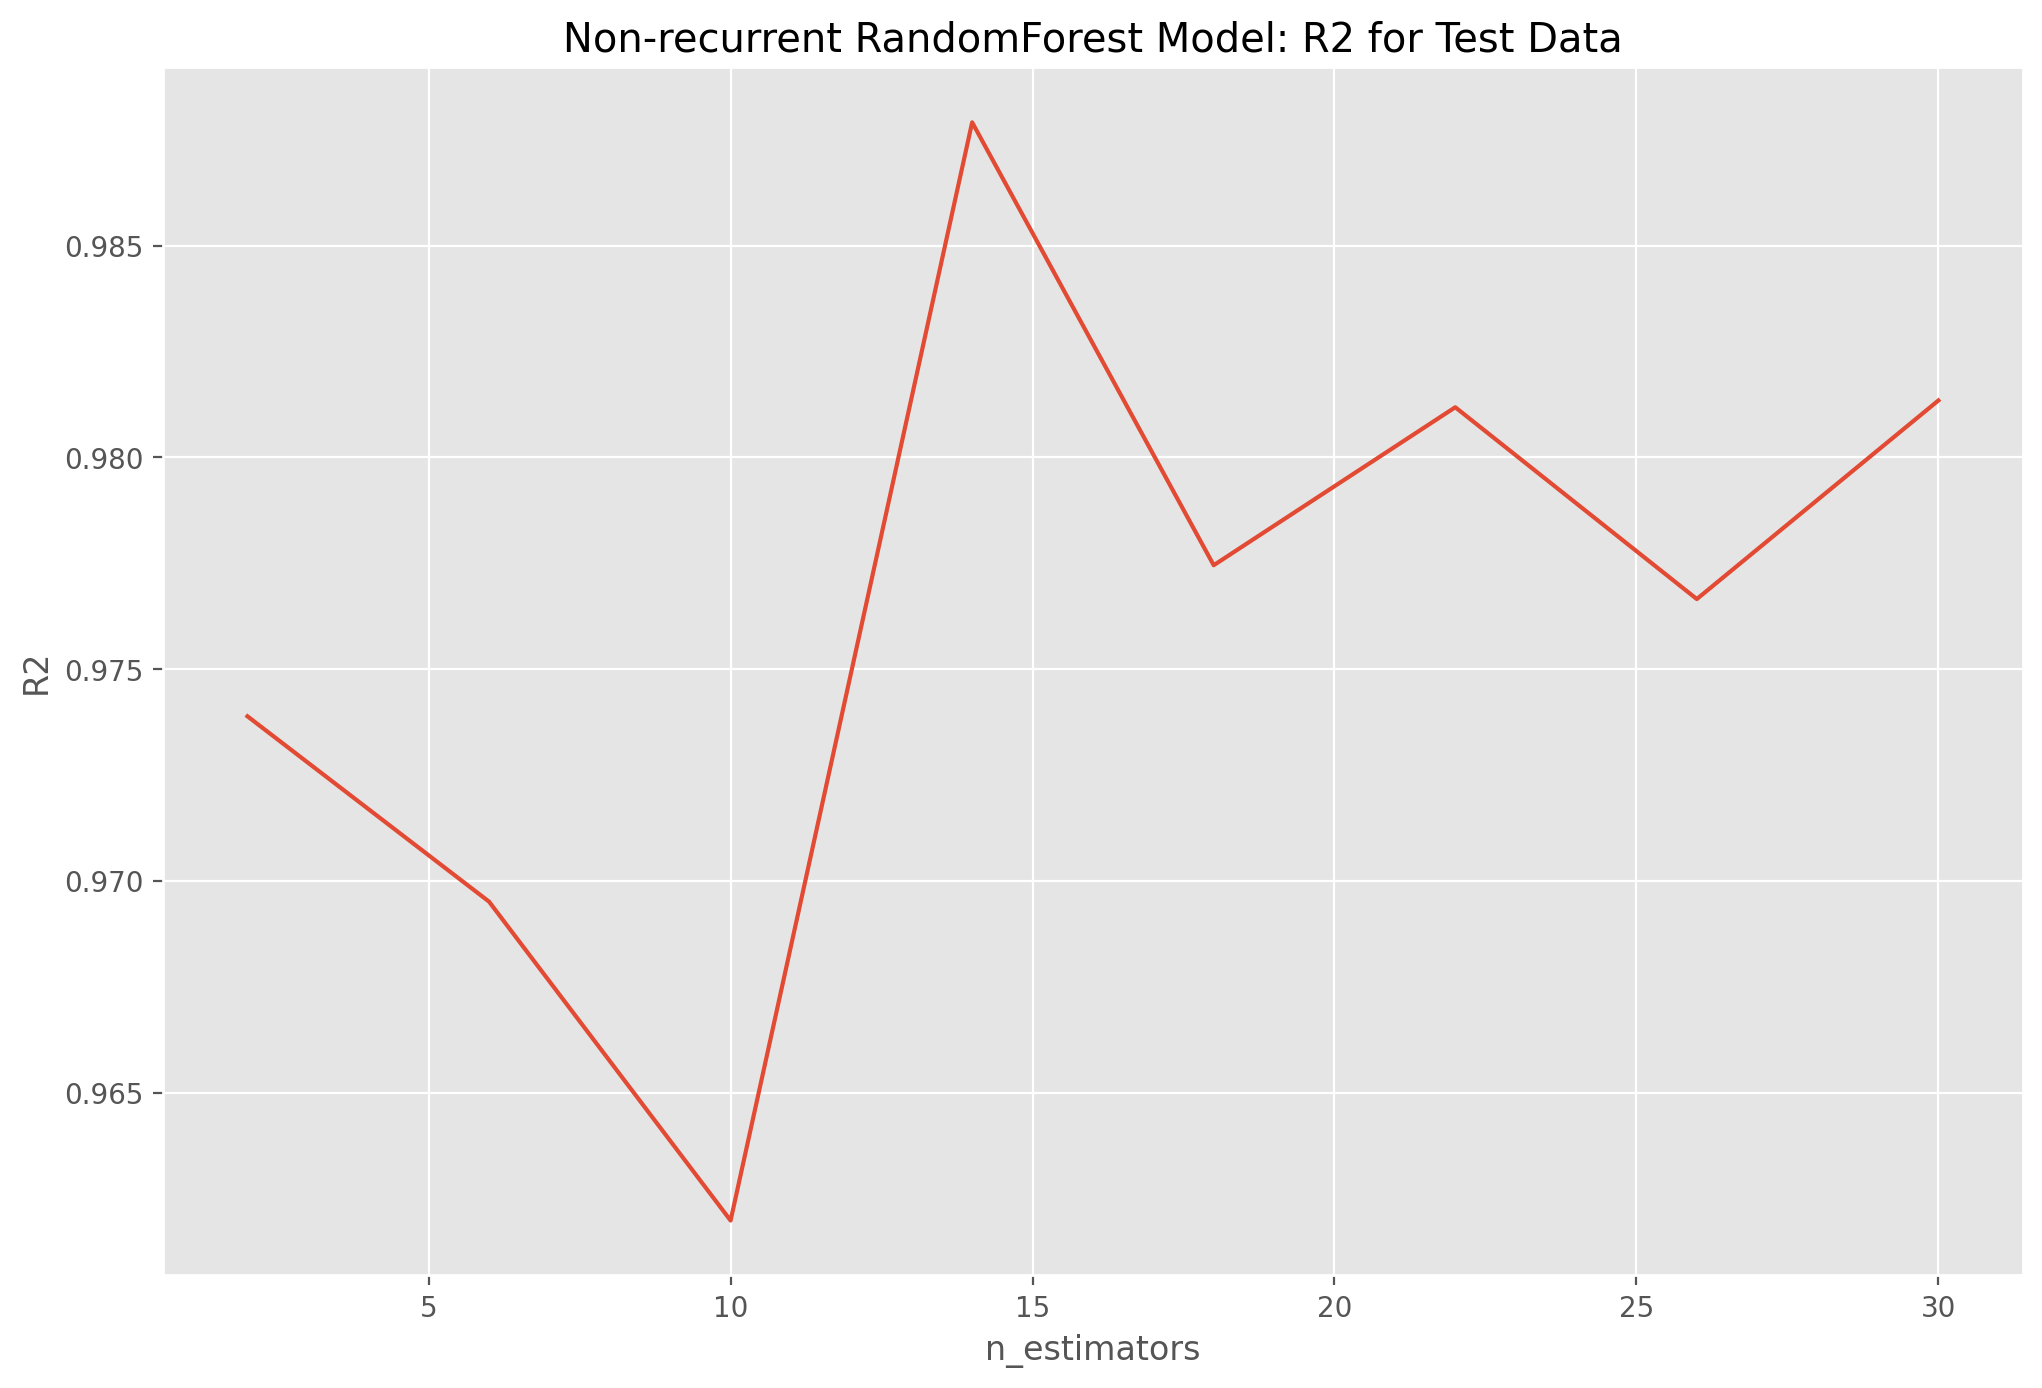

In [28]:
plot_progress_results(r2_history[0], model_type, is_recurrent, metric="R2")

In [5]:
model_type = 'XGBoost'
is_recurrent = False
target = 'h'
n_estimators = 300
n_shuffle_iterations = 5
per_case = False
x = 0

rmse_history, r2_history = get_shuffle_results(model_type, scenario_index, n_estimators, n_shuffle_iterations, is_recurrent, verbose=1, target=target, per_case=per_case, x=x)

KeyboardInterrupt: 